# Differentiable programming for particle physics simulations
#### Roland Grinis - researcher at MIPT Nuclear Physics Methods lab, CTO at GrinisRIT (grinisrit.com)

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

Keep an eye on `KMath` [github.com/mipt-npm/kmath](https://github.com/mipt-npm/kmath) - Maths library in `Kotlin` (thanks to JetBrains Research for support)

## Introduction
In this workshop we will explore the challenges and opportunities that arise in integrating `automatic differentiation (AD)` platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful `AD` engines such as [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/). Since then, those technologies grew up into full-fledged `differentiable programming (DP)` frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between `DP`, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. We shall mention here the packages [torchdiffeq](https://github.com/rtqichen/torchdiffeq) and [diffeqflux](https://diffeqflux.sciml.ai/dev/) developed respectively by:

* R. Chen et al., *Neural ordinary differential equations*, Advances in Neural Information Processing Systems (2018)
* C. Rackauckus et al., *Universal differential equations for scientific machine learning*, arXiv preprint arXiv:2001.04385 (2020)

On one hand, we obtain a more flexible framework with a wealth of new tools for a data-driven approach to mathematical modelling that opens the door to solving applied problems that we couldn't tackle before. On the other hand, many techniques such as the `adjoint sensitivity methods` gave rise to whole new powerful algorithms for `AD`. 

Unsurprisingly, one can find some roots of this story in computational finance as well, see for example:

* M. Giles et al., *Algorithmic Differentiation: Adjoint Greeks Made Easy*. SSRN Electronic Journal (2011)

But in particle physics simulations, a similar picture is left almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the `Backward Monte-Carlo` techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples.

In [1]:
import torch
from torch.utils.cpp_extension import load
import torch.autograd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [3]:
# Load C++ extensions
diffpms = load(name='diffpms',
             sources=['diffpms.cc'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [4]:
# Load CUDA extensions
diffpms_cuda = load(name='diffpms_cuda',
             sources=['diffpms.cu'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

## Backward Monte-Carlo 

Several implementations have been considered, including for electrons/positrons, protons and more recently muons:

* L. Desorgher et al., *Implementation of the reverse/adjoint Monte Carlo method into Geant4*, Nucl. Instrum. Meth. (2010)
* V. Niess et al., *Backward Monte-Carlo applied to muon transport*, Comput. Phys. Comm. (2018)

The latter is backed by a `C99` muon transport library [PUMAS](https://github.com/niess/pumas). In fact, the need for a `BMC` approach arises naturally in many problems from `muography`:

<img src="muography.png" />

Image credits: Z. X. Zhang et al., *Muography and Its Potential Applications to Mining and Rock Engineering*, Rock Mechanics and Rock Engineering 53, 4893-4907, (2020)

This Monte-Carlo technique seeks to reverse the simulation from a given final state up to a distribution of initial states.

In [3]:
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)

In [4]:
def level_set(t, node, x):
    zz02 = (-node[2] * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

def plot_detector(detector, node_param, x = torch.linspace(-5., 5., 500)):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])

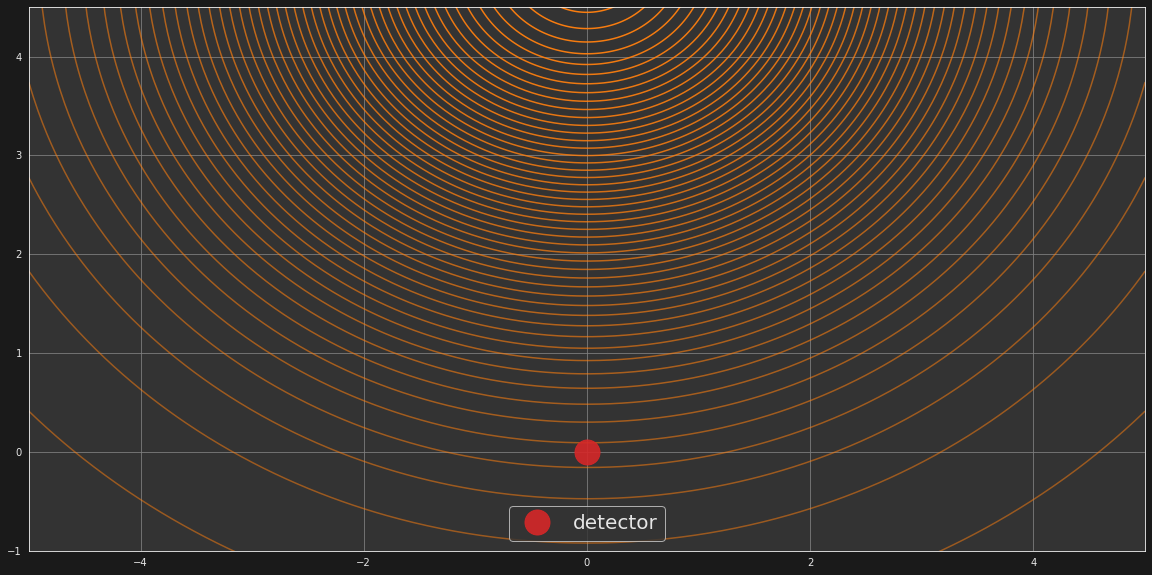

In [6]:
plot_detector(detector, knode)

In [18]:
material_A = 0.01
material_B = 0.9
PI = 2 * torch.acos(torch.tensor(0.))
thetas = PI * torch.tensor([0.1,0.0, -0.08]) 

In [13]:
def mix_density(state, node):
    return torch.exp(-(state - node[:2]).pow(2).sum(1) / node[2].abs())

In [14]:
def rot(theta):
    n = theta.numel()
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([c,-s, s, c]).T.reshape((n,2,2))

In [213]:
def backward_mc(theta, node, npar):
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.reshape((npar, 2,1))).view((npar, 2))
    state1 = detector + step1

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state1, node)
    weights = torch.where(biasing > 0, (density/0.5) * material_A, ((1 - density)/0.5) * material_B) * torch.exp(-0.01*length1) 
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * PI * (torch.rand(npar) - 0.5))
    step2 = length2.reshape((npar,1)) * step1 / length1.reshape((npar,1))
    step2 = rot2.matmul(step2.reshape((npar,2,1))).view((npar, 2))
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state2, node)
    weights *= torch.where(biasing > 0, (density/0.5) * material_A, ((1 - density)/0.5) * material_B) * torch.exp(-0.01*length2) 
    
    return weights, [state1, state2]

In [60]:
bmcs = []
for theta in thetas:
    _, bmc = backward_mc(theta, knode, 10)
    bmcs.append(torch.stack(bmc).transpose(0,1))

In [45]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, detector, node_param):
    plot_detector(detector, node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

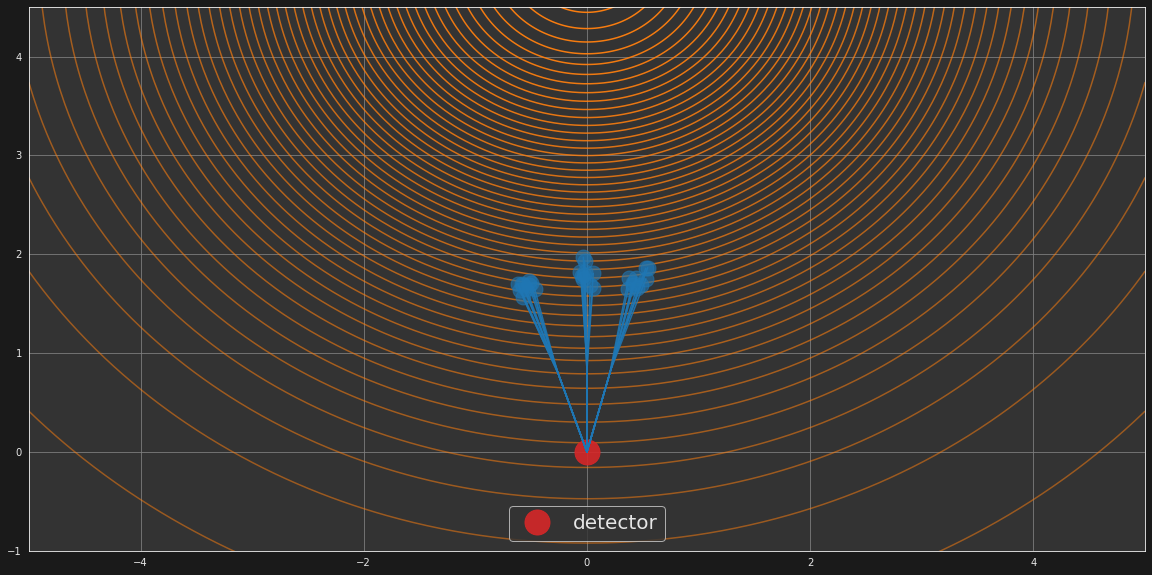

In [61]:
plot_bmc(bmcs, detector, knode)

In [214]:
for theta in thetas:
    print(f'Flux at {round(theta.item(),2)}: {backward_mc(theta, knode, 100000)[0].mean()}')

Flux at 0.31: 0.4435354769229889
Flux at 0.0: 0.41727545857429504
Flux at -0.25: 0.4335040748119354


In [216]:
def log_prob_flux(node_params):
    log_prob = torch.tensor(0.)
    for i in range(len(thetas)):
        log_prob += (observed_flux[i] - backward_mc(thetas[i], node_params, 100000)[0].mean()).pow(2) / 0.01
    return - log_prob

In [217]:
knodeg = knode.clone().requires_grad_()
pflux = - log_prob_flux(knodeg)
dpflux = torch.autograd.grad(outputs=pflux, inputs=knodeg)[0]
dpflux

tensor([ 0.3125, -7.9035,  1.4115])

In [219]:
def eval_gradient(node_params):
    nodeg = node_params.detach().requires_grad_()
    pflux = - log_prob_flux(nodeg)
    dpflux = torch.autograd.grad(outputs=pflux, inputs=nodeg)[0]
    return dpflux

In [220]:
nu = 0.05
N = 601
gdescent = torch.zeros(N) 

In [221]:
inode = torch.tensor([5.,5.,10.]) 
new_knode = inode - nu * eval_gradient(inode)  
res = []
for i in range(N):
    g = eval_gradient(new_knode)
    new_knode -= nu * g / (g.norm() + 1.0)
    gdescent[i] = - log_prob_flux(new_knode)
    if i % 50 == 0:
        print(f'log probability : {gdescent[i]}')
        print(f'node {i} : {new_knode}')
    if i > (N-100):
        res.append(new_knode.detach().clone())

log probability : 19.087661743164062
node 0 : tensor([ 4.6995,  4.7854, 10.1126])
log probability : 1.7843525409698486
node 50 : tensor([ 3.1545,  3.8568, 10.5943])
log probability : 1.577584147453308
node 100 : tensor([ 2.7198,  4.3844, 10.7751])
log probability : 1.1690409183502197
node 150 : tensor([ 2.1193,  4.8497, 10.9144])
log probability : 0.7694146633148193
node 200 : tensor([ 1.4410,  5.1987, 11.0053])
log probability : 0.5364851355552673
node 250 : tensor([ 0.7547,  5.4038, 11.0581])
log probability : 0.29278868436813354
node 300 : tensor([ 0.1419,  5.4649, 11.0846])
log probability : 0.1615784764289856
node 350 : tensor([-0.3528,  5.4753, 11.0876])
log probability : 0.0716804713010788
node 400 : tensor([-0.7214,  5.4048, 11.0896])
log probability : 0.06748742610216141
node 450 : tensor([-0.9915,  5.3609, 11.0820])
log probability : 0.03345339000225067
node 500 : tensor([-1.1785,  5.3083, 11.0773])
log probability : 0.01818902976810932
node 550 : tensor([-1.3249,  5.2681, 11

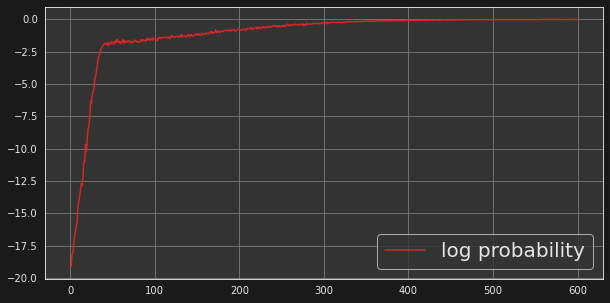

In [222]:
plt.figure(figsize=(10,5))
plt.plot(torch.arange(N).numpy(), -gdescent.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

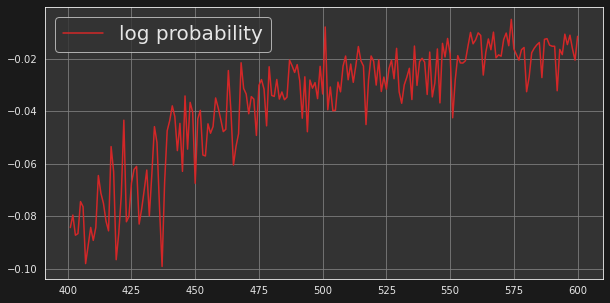

In [223]:
plt.figure(figsize=(10,5))
plt.plot(torch.arange(N).numpy()[-200:], -gdescent.numpy()[-200:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [224]:
optimal_node = torch.stack(res[-50:]).mean(0)
optimal_node

tensor([-1.3742,  5.2444, 11.0711])

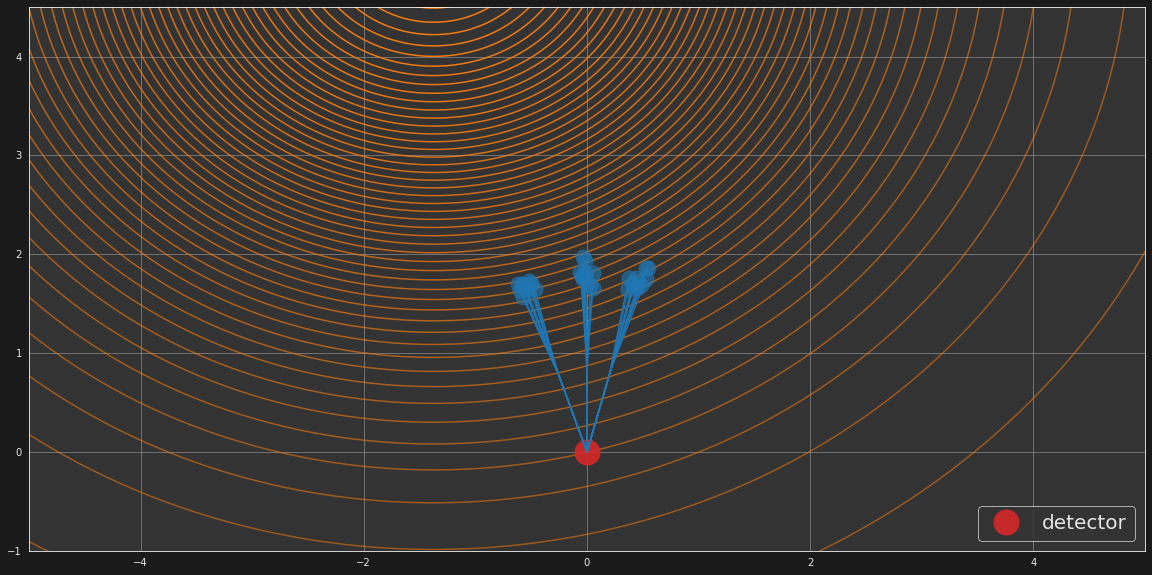

In [225]:
plot_bmc(bmcs, detector, optimal_node)

In [209]:
def backward_mc_grad(theta, node):
    npar = 1
    bmc_grad = torch.zeros_like(node)
    
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.reshape((npar, 2,1))).view((npar, 2))
    state1 = detector + step1

    biasing = torch.randint(0,2, (npar,))
    
    nodeg = node.detach().requires_grad_()
    densityg = mix_density(state1, nodeg)
    weightsg = torch.where(biasing > 0, (densityg/0.5) * material_A, ((1 - densityg)/0.5) * material_B) * torch.exp(-0.01*length1) 
    bmc_grad += torch.autograd.grad(outputs=weightsg, inputs=nodeg)[0]
    weights = weightsg.detach()
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * PI * (torch.rand(npar) - 0.5))
    step2 = length2.reshape((npar,1)) * step1 / length1.reshape((npar,1))
    step2 = rot2.matmul(step2.reshape((npar,2,1))).view((npar, 2))
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    
    nodeg = node.detach().requires_grad_()
    densityg = mix_density(state2, nodeg)
    weightsg = torch.where(biasing > 0, (densityg/0.5) * material_A, ((1 - densityg)/0.5) * material_B) * torch.exp(-0.01*length2) 
    weight2 = weightsg.detach()
    bmc_grad = weights * torch.autograd.grad(outputs=weightsg, inputs=nodeg)[0] + weight2 * bmc_grad
    weights *= weight2
    
    return weights, bmc_grad

In [232]:
torch.manual_seed(3)
backward_mc_grad(thetas[1], knode)

(tensor([1.5430]), tensor([-0.0139,  0.9203, -0.1555]))

In [231]:
torch.manual_seed(3)
knodeg = knode.clone().requires_grad_()
flux = backward_mc(thetas[1], knodeg, 1)[0]
print(flux)
dflux = torch.autograd.grad(outputs=flux, inputs=knodeg)[0]
dflux

tensor([1.5430], grad_fn=<MulBackward0>)


tensor([-0.0139,  0.9203, -0.1555])

In [3]:
# Load CUDA extensions
diffpms_cuda = load(name='diffpms_cuda',
             sources=['diffpms.cu'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

In [4]:
kinetic_energies = torch.linspace(1e-3, 1e6, 100).double().cuda()
recoil_energies = 0.0505 * kinetic_energies

In [5]:
brems = diffpms.bremsstrahlung_cuda(kinetic_energies, recoil_energies)